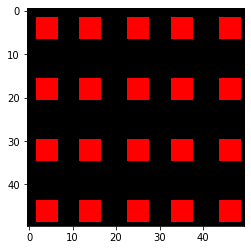

In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Tuple, Set, List
from enum import Enum
from itertools import permutations, combinations_with_replacement
import math

cmap = matplotlib.colors.ListedColormap(['r', 'k'])
norm = matplotlib.colors.BoundaryNorm([0., 0.5, 1.], cmap.N)

def imshow(data, cmap, norm):
    plt.imshow(data, cmap=cmap, norm=norm, interpolation='none')

class RandomExclusionSet(object):
    def __init__(self, *, n_voids, size, depth, layer, rows):
        self.n_voids = n_voids
        self.size = size
        self.depth = depth
        self.layer = layer
        self.rows = rows
        self.cols = self.n_voids // self.rows
        
    def __len__(self):
        return self.n_voids * self.size
        
class IsotropicVoxelGrid(object):
    def __init__(
        self, 
        dataset_size: int,
        layers: int,
    ):
        self.dataset_size = dataset_size
        self.layers = layers
        
    def __call__(self, exclusions: List[RandomExclusionSet]):
        self.grid = np.ones((self.layers, self.dataset_size, self.dataset_size))
        for exclusion in exclusions:
            self._apply_exclusion(exclusion)
        
    def _apply_exclusion(self, exclusion: RandomExclusionSet):
        # Evenly subdivide along y-axis
        y_axis_origins = np.linspace(
            exclusion.size + 1, 
            self.dataset_size-(exclusion.size + 1), 
            num=exclusion.rows
        ) if exclusion.rows > 1 else [math.ceil(self.dataset_size / 2)]

        centroids = []
        for row in range(exclusion.rows):
            x_axis_layout = np.linspace(
                exclusion.size + 1, 
                self.dataset_size - (exclusion.size + 1), 
                num=exclusion.cols
            )
            y_axis_val = y_axis_origins[row]

            for x_axis_val in x_axis_layout:
                centroids.append((int(x_axis_val), int(y_axis_val)))
        indices = []
        for centroid in centroids:
            indices.extend(self._construct_cube_indices(centroid, exclusion.layer, exclusion.depth, exclusion.size))

        self._set_shape_from_indices(indices)
        
    
    def _set_shape_from_indices(self, indices: List[Tuple[int, int, int]]):
        for index in indices:
            self.grid[index[0]][index[1]][index[2]] = 0
    
    def _construct_cube_indices(self, centroid: Tuple[int, int], layer: int, depth: int, size: int):
        indices = []

        for l in range(layer, layer + depth):
            cur_x = centroid[0]
            cur_y = centroid[1]
            for x in range(size):
                for y in range(size):
                    indices.append((l, cur_x + x, cur_y + y))
                    indices.append((l, cur_x - x, cur_y - y))
                    indices.append((l, cur_x - x, cur_y + y))
                    indices.append((l, cur_x + x, cur_y - y))
                
        indices = list(set(indices))
        return indices

isotropic_solver = IsotropicVoxelGrid(50, 50)
solver_sets = [
    RandomExclusionSet(n_voids=20, size=3, depth=5, layer=i, rows=5)
    for i in range(0, isotropic_solver.layers, 11)
]

isotropic_solver(solver_sets)
imshow(isotropic_solver.grid[0], cmap, norm)

In [31]:
class IsotropicLinearComplianceMatrix(object):
    """
    Compliance matrix for a linear tetrahedral element in finite element anlysis.
    This matrix is the inverse of the stiffness matrix (K) in FEM and is useful 
    for translating displacement values into force or stress tensors.
    """
    def __init__(self, E: float, v: float):
        # Young's Modulus
        self.E = E

        # Poisson's Ratio
        self.v = v

        # Shear modulus
        self.G = E / (2 * (1 + v))

        # Lame's Parameters
        # https://en.wikipedia.org/wiki/Lam%C3%A9_parameters
        # Conversion table here ^
        self.lambda_ = (self.E * self.v) / ((1 + self.v) * (1 - 2 * self.v))

        self.mu = self.G

    def  __call__(self, stress_tensor: np.array):
        self.consitutuve_matrix = np.identity(6)
        self.consitutuve_matrix[0] = [1, -self.v, -self.v, 0, 0, 0]
        self.consitutuve_matrix[1] = [0, 1, -self.v, 0, 0, 0]
        self.consitutuve_matrix[3][3] = 2 * (self.v + 1)
        self.consitutuve_matrix[4][4] = 2 * (self.v + 1)
        self.consitutuve_matrix[5][5] = 2 * (self.v + 1)
        return (1 / self.E) * self.consitutuve_matrix * stress_tensor

    @property
    def params(self):
        """Returns the compliance matrix params

        Returns:
            Tuple[int, int, int] E, v, G
        """
        return (self.E, self.v, self.G)



compliance_matrix_solver = IsotropicLinearComplianceMatrix(10000, 0.3)
compliance_matrix_solver(np.array([1, 2, 3, 4, 5, 6]))
compliance_matrix_solver.params


(10000, 0.3, 3846.153846153846)

In [ ]:
class IsotropicMeshInputSetGenerator(object):
    def __init__(self, voxel_grid: IsotropicVoxelGrid):
        self.voxel_grid = voxel_grid